## Detecting Objects (bubble) and measure their properties

The first algorithm uses the contour function. Contours are lines with the same intensity level.

In [61]:
#libraries for image processing
from skimage import measure
from skimage.draw import circle_perimeter_aa
from skimage.color import rgb2gray
#libraries for plotting
import matplotlib.pyplot as plt
#libraries for matrix algebra
import numpy as np
#libraries for loading and storing images/movies
import imageio
#libraries for analyzing polygons
from shapely.geometry import Polygon

#image range
N = 102
N_start = 0

#threshold for detecting an object
my_thresh = 90

#crop range
x1,x2= 50,250
y1,y2= 120,250

#file to analyse are listed here 
experiment_video='Camera1_15_00_13_BigBub_Hydrophone1mm_500k_7V.AVI'
label='Gel. 8% near hyd.'

fr=2. #frame interval time in microseconds
scale=1e-5 #size of one pixel in m

#read images from the movies into a numpy array simplifies things if video is not too long
mo = imageio.mimread(experiment_video)

mov = np.asarray(([rgb2gray(mo[nn]) for nn in range(len(mo))]))*256

#crop image
mov = mov[:,y1:y2,x1:x2]

mov2=np.copy(mov)

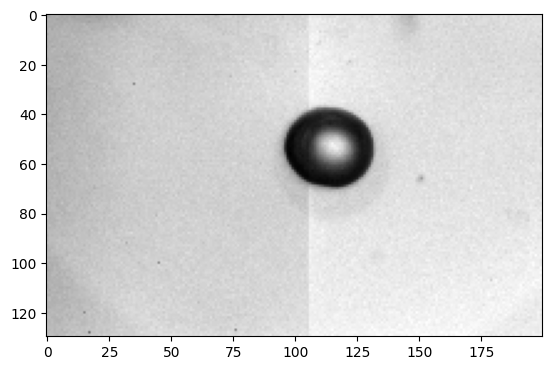

In [57]:
plt.imshow(mov2[10,:,:],cmap='gray');

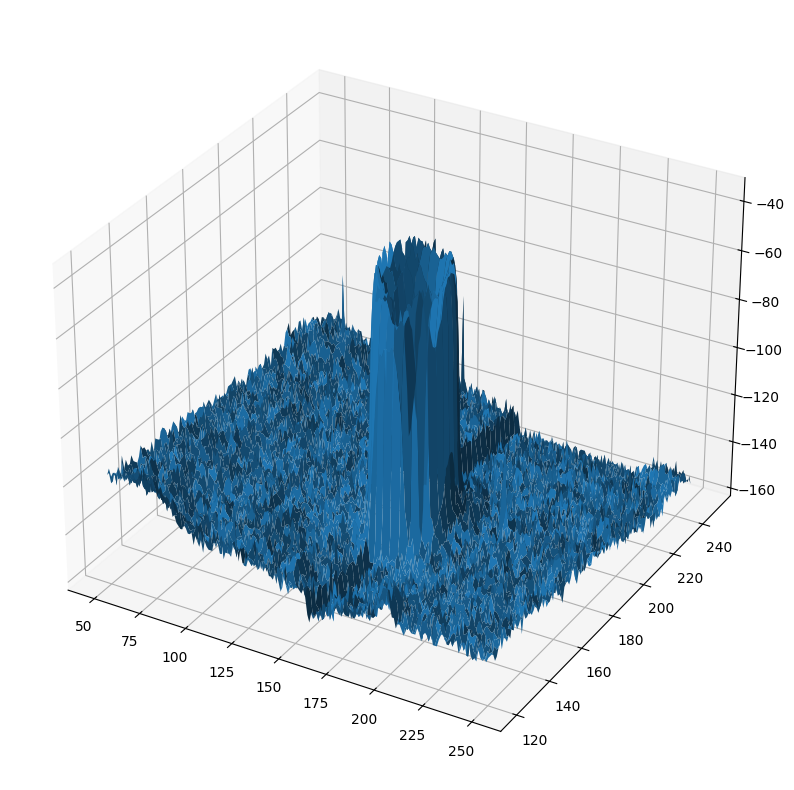

In [60]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(np.linspace(x1,x2,x2-x1), np.linspace(y1,y2,y2-y1))
ax.plot_surface(X,Y,-mov2[10,:,:]);

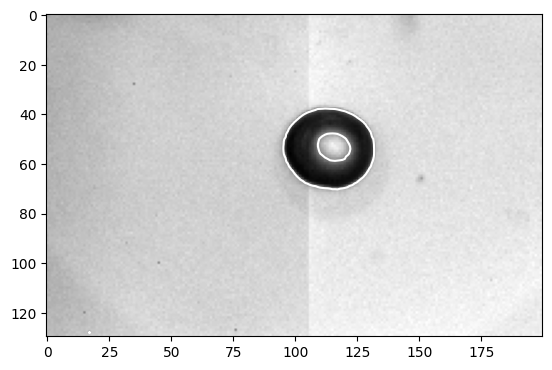

In [35]:
plt.imshow(mov2[10,:,:],cmap='gray')
plt.contour(mov2[10,:,:],[100],colors='w')

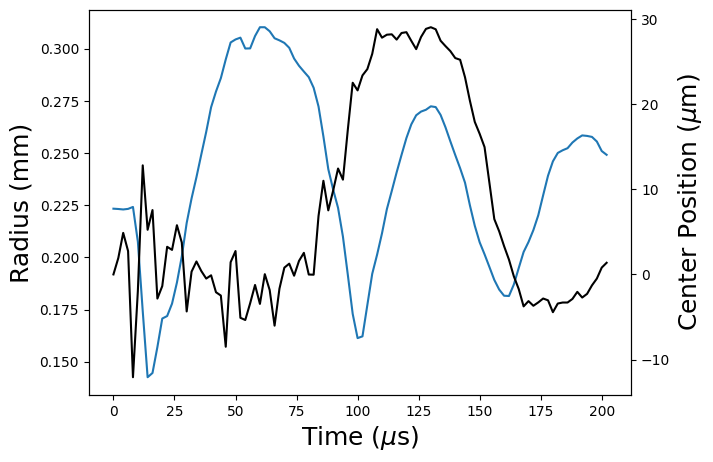

In [62]:
#list of contours for the detected bubbles
kl=list()

for i in range(N_start,N):

    #select one image
    img = mov[i]
    
    # calculate contour with a fixed threshold
    cont=measure.find_contours(img, my_thresh)
    
    # find the longest contour, this is likely the biggest bubble
    l=np.asarray([len(cont[nn]) for nn in range(len(cont))])
    y=cont[l.argmax()][:,0]
    x=cont[l.argmax()][:,1]
    
    # store contour as polygon
    k=Polygon(np.asarray([x,y]).T);
    
    # save polygon
    kl.append(k)
    
    # add circle on top of images for later verification
    rr, cc, val=circle_perimeter_aa(int(k.centroid.y), int(k.centroid.x),\
                                    int(np.sqrt(k.area/np.pi)))
    mov[i, rr, cc] = val * 255

        
#generate time and radius date
t_data=np.linspace(0,N-N_start-1,N-N_start)*fr*1e-6
R_data=(np.asarray([kl[nn].area for nn in range(len(kl))])/np.pi)**.5*scale

#calculate displacement of centroid 
centroids=[kl[nn].centroid for nn in range(len(kl))]
dist=np.asarray([centroids[0].y-centroids[nn].y for nn in range(len(centroids))])*1e-5

#start the plotting
plt.figure(figsize=(7,5),dpi=100)
ax1=plt.gca()
#plot radius and position
ax1.plot(t_data*1e6,R_data*1e3)
ax2 = ax1.twinx() 
ax2.plot(t_data*1e6,dist*1e6,'k')
ax1.set_ylabel('Radius (mm)',fontsize=18)
ax1.set_xlabel(r'Time ($\mu$s)',fontsize=18)
ax2.set_ylabel(r'Center Position ($\mu$m)',fontsize=18);

ValueError: x and y must have same first dimension, but have shapes (1000,) and (102,)

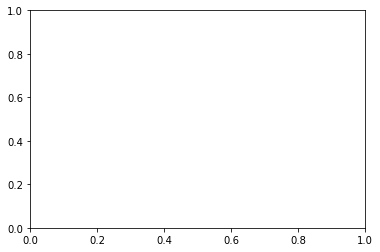

In [5]:
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
#from skimage import data
#from skimage import filters
#from scipy import ndimage as ndi
R_dataf=savgol_filter(R_data, 51, 3)
t=np.linspace(0,200,1000)*1e-6
fR=interp1d(t_data, R_dataf, kind='cubic')
R=fR(t)
Rt=np.gradient(R,t)
Rtt=np.gradient(Rt,t)
p=-(R*Rtt+1.5*Rt**2.)*1e3
#plt.plot(t*1e6,p/1e5)
plt.plot(t*1e6,R_dataf)

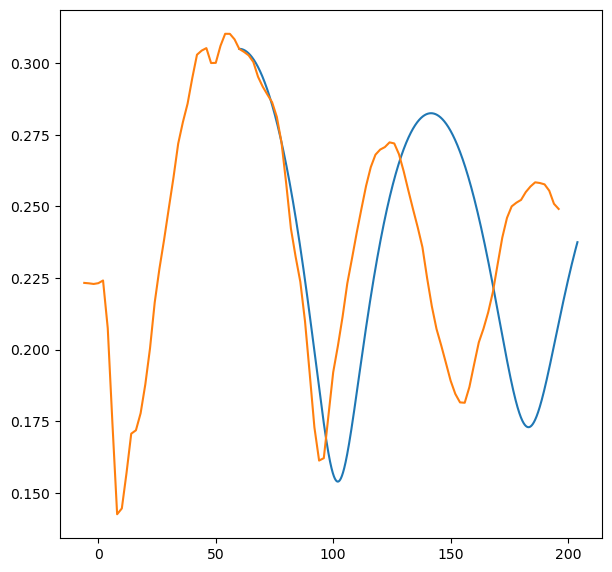

In [6]:
%matplotlib inline 

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.integrate as integrate
from scipy.optimize import least_squares
import numpy as np #work with arrays
import pandas as pd
 
df = pd.read_csv("/Users/cdohl/Documents/tempstore/siewwan/Camera1_15_00_13_BigBub_Hydrophone1mm_500k_7V.csv")
#th=df['time_microsec']
#ph=df['pressure_bar']
#ph=ph[np.where(th>130)[0][0]:].values*1e5*2.
#th=th[np.where(th>130)[0][0]:].values*1e-6
#reformate 
#th=np.linspace(0,(th[2]-th[1])*(th.size-1),th.size)

ph=(np.asarray(df['CH1'].values[1:-1],dtype=float))/1.28e-3*1e5*2.15
dt=float(df['Increment'].values[0])
th=np.linspace(0,len(ph)-1,len(ph))*dt
ts_i=np.where(th>150e-6)[0]
th=th-th[ts_i[0]]
ph=ph #some offset on the pressure to remove


dydt=np.zeros(2) #global array variable

p0=1e5            # ambient pressure
rho=1e3           # density of the liquid
R0=R_data[0]
nu=1e-4           # Viscosity in m^2/s
c=1.5e3
pv=0.             # vapour pressure
sigma=0.072       # Surface tension N/m
kappa=1.0
eta=5e4           # Elasticity parameter
alpha=1.          # paramerer for Fung
eta_kind=0


#E(eta,alpha,R0,y[0],Rmax)
#  a   b    c  d    e 

E=lambda a,b,c,d,e : 0.                      #Newtonian
        
if (eta_kind == 1):                          #Neo-Hookean
    E=lambda a,b,c,d,e : a/2.*(5.-4.*(c/d)-(c/d)**4.) 
if (eta_kind == 2):                          #Yang & Church
    E=lambda a,b,c,d,e : 4.*a/3.*(1-(c/d)**3.)            
if (eta_kind == 3):                          #Linear elastic
    E=lambda a,b,c,d,e : 2.*a*(1-(c/d)**2.)               
if (eta_kind == 4):                          #Fung et al.
    E=lambda a,b,c,d,e : -2.*a*integrate.quad(lambda x: (x**-5+x**-2)*np.exp(b*(x**-4+2.*x**2-3.)), d/e, 1.)[0]



#Rayleigh Plesset Equation
def rp(y,t):
    pa=0.
    if t<t0:
        pa=np.interp(t,th,ph)
    pinfty = p0+pa
    pg0 = p0+2.*sigma/R0-pv
    dydt0 = y[1] 
    dydt1 = (pv-pinfty+pg0*(R0/y[0])**(3.*kappa)\
            -2.*sigma/y[0])/rho/y[0]-1.5*y[1]**2./y[0]\
            -4.*nu*y[1]/y[0]/y[0]-E(eta,alpha,R0,y[0],R0)/rho/y[0]
    return [dydt0,dydt1]

def km(y,t):
    pa=0.
    if t<50e-6:
        pa=np.interp(t,th,ph)
    pinfty = p0+pa
    pl=(pinfty-pv+2.*sigma/R0)*(R0/y[0])**(3.*kappa)-pinfty+pv-2.*sigma/y[0]\
        -4.*nu*rho*y[1]/y[0]
    dydt0 = y[1]
    dydt1 = 1./(4.*nu/c+(1-y[1]/c)*y[0])*\
            (-1.5*y[1]*y[1]*(1-y[1]/3./c)+(1.+y[1]/c)*pl/rho\
            -3.*kappa/rho/c*(pinfty-pv+2.*sigma/R0)*(R0/y[0])**(3.*kappa)*y[1]\
            +2.*sigma/rho/c*y[1]/y[0]+4.*nu/c*y[1]*y[1]/y[0])
             
    return [dydt0,dydt1]



#tosc=0.914*Rmax*np.sqrt(rho/p0)    #estimated from the Rayleigh collapse time
t_final = 204e-6
Rmax=305e-6
t0=60e-6

# Initial condition
y0=[Rmax,0]

# Times for the solution
t = np.linspace(t0, t_final, 10000)
eta_kind=1
sol=odeint(rp, y0, t)
R1=sol[:, 0]
plt.figure(figsize=(7,7),dpi=100)
ax1=plt.gca()
ax1.plot(t*1e6,R1*1e3,t_data*1e6-6.,R_data*1e3)


'''
eta_kind=1
sol=odeint(rp, y0, t,)
R1=sol[:, 0]
eta_kind=2
sol=odeint(rp, y0, t)
R2=sol[:, 0]
eta_kind=3
sol=odeint(rp, y0, t)
R3=sol[:, 0]
eta_kind=4
sol=odeint(rp, y0, t)
R4=sol[:, 0]
eta_kind=0
sol=odeint(rp, y0, t)
R5=sol[:, 0]


plt.figure(figsize=(7,7),dpi=100)
ax1=plt.gca()
[h1,h2,h3,h4,h5]=ax1.plot(t/dt,R1/Rmax,t/dt,R2/Rmax,t/dt,R3/Rmax,t/dt,R4/Rmax,t/dt,R5/Rmax)
ax1.set_xlabel(r'$t/\Delta t$',size=25);ax1.set_ylabel(r'$R/R_{max}$', size=25)
ax1.tick_params(labelsize=20)
ax1.legend([h1,h2,h3,h4,h5],['Neo-Hookean','Yang, Church','Linear','Fung','Newtonian']);
''';

(-10.0, 200.0)

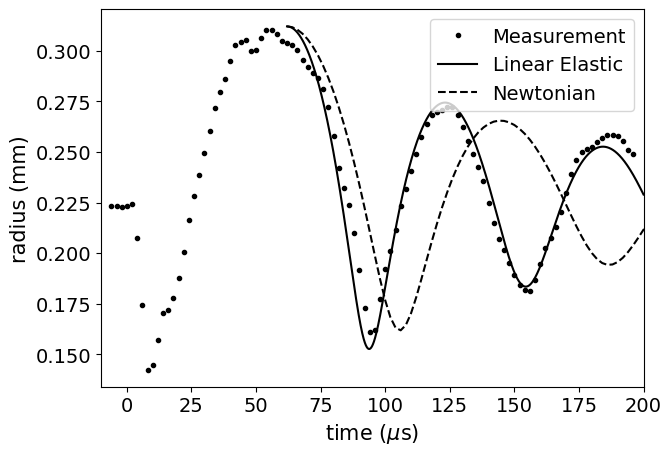

In [3]:
%matplotlib inline 

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.integrate as integrate
from scipy.optimize import minimize
import numpy as np #work with arrays
import pandas as pd
 

dydt=np.zeros(2) #global array variable

p0=1e5            # ambient pressure
rho=1e3           # density of the liquid
R0=R_data[0]
nu0=2.3e-4           # Viscosity in m^2/s
nu=nu0
c=1.5e3
pv=0.             # vapour pressure
sigma=0.072       # Surface tension N/m
kappa=1.0
eta0=5.8e4           # Elasticity parameter
eta=eta0
alpha=1.          # paramerer for Fung
eta_kind=3

t_final = 200e-6
Rmax=312e-6
t0=62e-6

#E(eta,alpha,R0,y[0],Rmax)
#  a   b    c  d    e 

E=lambda a,b,c,d,e : 0.                      #Newtonian
        
if (eta_kind == 1):                          #Neo-Hookean
    E=lambda a,b,c,d,e : a/2.*(5.-4.*(c/d)-(c/d)**4.) 
if (eta_kind == 2):                          #Yang & Church
    E=lambda a,b,c,d,e : 4.*a/3.*(1-(c/d)**3.)            
if (eta_kind == 3):                          #Linear elastic
    E=lambda a,b,c,d,e : 2.*a*(1-(c/d)**2.)               
if (eta_kind == 4):                          #Fung et al.
    E=lambda a,b,c,d,e : -2.*a*integrate.quad(lambda x: (x**-5+x**-2)*np.exp(b*(x**-4+2.*x**2-3.)), d/e, 1.)[0]



#Rayleigh Plesset Equation
def rp(y,t):
    pa=0.
    pinfty = p0+pa
    pg0 = p0+2.*sigma/R0-pv
    dydt0 = y[1] 
    dydt1 = (pv-pinfty+pg0*(R0/y[0])**(3.*kappa)\
            -2.*sigma/y[0])/rho/y[0]-1.5*y[1]**2./y[0]\
            -4.*nu*y[1]/y[0]/y[0]-E(eta,alpha,R0,y[0],R0)/rho/y[0]
    return [dydt0,dydt1]


#tosc=0.914*Rmax*np.sqrt(rho/p0)    #estimated from the Rayleigh collapse time

t = np.linspace(t0, t_final, 10000)
t_pdata=t_data[31:]
R_pdata=R_data[31:]

# Initial condition

#x0=[nu,eta]
x0=[nu]   

def myopt(x):
    global eta, nu, Rmax
    nu=x[0]
    #eta=x[1]
    y0=[Rmax,0]
    sol=odeint(rp, y0, t)
    R1=sol[:, 0]
    R1int=np.interp(t_pdata,t,R1)
    #print(sum((R1int-R_pdata)**2))
    ret=sum(np.absolute((R1int-R_pdata))/(np.absolute(np.gradient(R1int))+1e-10))
    
    #ret=np.absolute((R1int-R_pdata))/(np.absolute(np.gradient(R1int))+1e-15)
    return ret

#res=least_squares(myopt, x0, method='lm',x_scale=[1e-3,1e4],verbose=2)
#res=minimize(myopt, x0, method='nelder-mead', options={'maxfev': 600, 'xatol': 1e-9, 'fatol': 1e-9, 'disp': True})


nu=nu0
eta=eta0#res.x[1]
sol=odeint(rp, [Rmax,0.], t)
R1=sol[:, 0]

nu=nu0
eta=eta0
E=lambda a,b,c,d,e : 0. 
sol=odeint(rp, [Rmax,0.], t)
Rorg=sol[:, 0]
Rorgint=np.interp(t_pdata,t,Rorg)

plt.figure(figsize=(7,5),dpi=100)
ax1=plt.gca()
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=13)
ax1.plot(t_data*1e6-6.,R_data*1e3,'k.',t*1e6,R1*1e3,'k-', t_pdata*1e6,Rorgint*1e3,'k--')
ax1.legend(('Measurement','Linear Elastic','Newtonian'),fontsize=14,loc='upper right')
ax1.set_xlabel('time ($\mu$s)',fontsize=15)
ax1.set_ylabel('radius (mm)',fontsize=15)
ax1.set_xlim((-10,200))



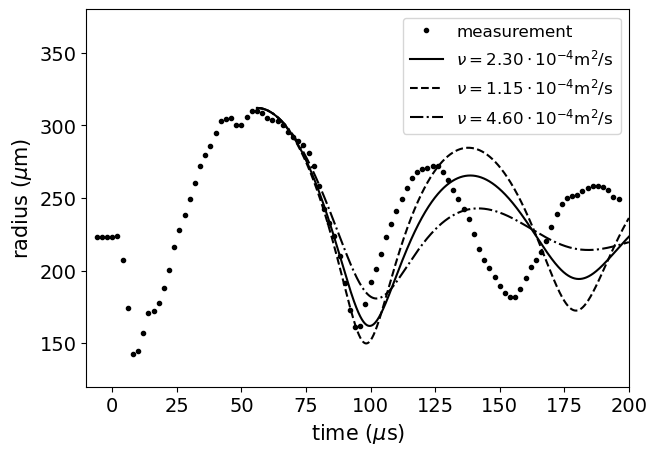

In [57]:
%matplotlib inline 

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.integrate as integrate
from scipy.optimize import minimize
import numpy as np #work with arrays
import pandas as pd
 

dydt=np.zeros(2) #global array variable

p0=1e5            # ambient pressure
rho=1e3           # density of the liquid
R0=R_data[0]
nu0=2.3e-4           # Viscosity in m^2/s
nu=nu0
c=1.5e3
pv=0.             # vapour pressure
sigma=0.072       # Surface tension N/m
kappa=1.0
eta0=5.8e4        # Elasticity parameter
eta=eta0
alpha=1.          # paramerer for Fung
eta_kind=0

t_final = 200e-6
Rmax=312e-6
t0=56e-6

#E(eta,alpha,R0,y[0],Rmax)
#  a   b    c  d    e 

E=lambda a,b,c,d,e : 0.                      #Newtonian
        
if (eta_kind == 1):                          #Neo-Hookean
    E=lambda a,b,c,d,e : a/2.*(5.-4.*(c/d)-(c/d)**4.) 
if (eta_kind == 2):                          #Yang & Church
    E=lambda a,b,c,d,e : 4.*a/3.*(1-(c/d)**3.)            
if (eta_kind == 3):                          #Linear elastic
    E=lambda a,b,c,d,e : 2.*a*(1-(c/d)**2.)               
if (eta_kind == 4):                          #Fung et al.
    E=lambda a,b,c,d,e : -2.*a*integrate.quad(lambda x: (x**-5+x**-2)*np.exp(b*(x**-4+2.*x**2-3.)), d/e, 1.)[0]



#Rayleigh Plesset Equation
def rp(y,t):
    pa=0.
    pinfty = p0+pa
    pg0 = p0+2.*sigma/R0-pv
    dydt0 = y[1] 
    dydt1 = (pv-pinfty+pg0*(R0/y[0])**(3.*kappa)\
            -2.*sigma/y[0])/rho/y[0]-1.5*y[1]**2./y[0]\
            -4.*nu*y[1]/y[0]/y[0]-E(eta,alpha,R0,y[0],R0)/rho/y[0]
    return [dydt0,dydt1]


#tosc=0.914*Rmax*np.sqrt(rho/p0)    #estimated from the Rayleigh collapse time

t = np.linspace(t0, t_final, 10000)
t_pdata=t_data[31:]
R_pdata=R_data[31:]

# Initial condition

#x0=[nu,eta]
x0=[nu]   

def myopt(x):
    global eta, nu, Rmax
    nu=x[0]
    #eta=x[1]
    y0=[Rmax,0]
    sol=odeint(rp, y0, t)
    R1=sol[:, 0]
    R1int=np.interp(t_pdata,t,R1)
    #print(sum((R1int-R_pdata)**2))
    ret=sum(np.absolute((R1int-R_pdata))/(np.absolute(np.gradient(R1int))+1e-10))
    
    #ret=np.absolute((R1int-R_pdata))/(np.absolute(np.gradient(R1int))+1e-15)
    return ret

#res=least_squares(myopt, x0, method='lm',x_scale=[1e-3,1e4],verbose=2)
#res=minimize(myopt, x0, method='nelder-mead', options={'maxfev': 600, 'xatol': 1e-9, 'fatol': 1e-9, 'disp': True})
nu1=nu0
nu2=nu0/2.
nu3=nu0*2.

E=lambda a,b,c,d,e : 0. 
nu=nu1
eta=eta0#res.x[1]
sol=odeint(rp, [Rmax,0.], t)
R1=sol[:, 0]

nu=nu2
eta=eta0
sol=odeint(rp, [Rmax,0.],t  )
R2=sol[:, 0]

nu=nu3
eta=eta0
sol=odeint(rp, [Rmax,0.],t  )
R3=sol[:, 0]

plt.figure(figsize=(7,5),dpi=100)
ax1=plt.gca()
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=13)
ax1.plot(t_data*1e6-6.,R_data*1e6,'k.',t*1e6,R1*1e6,'k-', t*1e6,R2*1e6,'k--', t*1e6,R3*1e6,'k-.')
ax1.legend(('measurement',r'$\nu={:4.2f}\cdot 10^{{-4}}$m$^2/$s'.format(nu1/1e-4),\
            r'$\nu={:4.2f}\cdot 10^{{-4}}$m$^2/$s'.format(nu2/1e-4),\
            r'$\nu={:4.2f}\cdot 10^{{-4}}$m$^2/$s'.format(nu3/1e-4)),fontsize=12,loc='upper right')
ax1.set_xlabel('time ($\mu$s)',fontsize=15)
ax1.set_ylabel(r'radius ($\mu$m)',fontsize=15)
ax1.set_xlim((-10,200))
ax1.set_ylim((120,380));

plt.savefig('Bubble_oscillation in 8% Gelatin.png',dpi=150)


In [52]:
nu1

0.00023

start nu=0.000233 end nu=0.000347
start eta=58000.000000 end eta=53520.743072
start Rmax=0.000312 end Rmax=0.000327


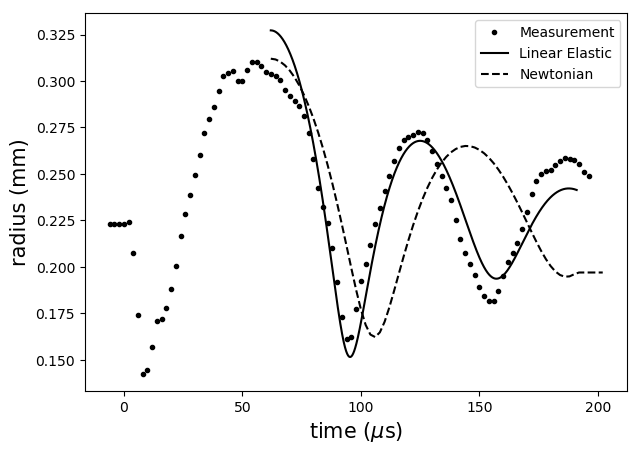

In [153]:
###### %matplotlib inline 

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.integrate as integrate
from scipy.optimize import minimize
import numpy as np #work with arrays
import pandas as pd
 

dydt=np.zeros(2) #global array variable

p0=1e5            # ambient pressure
rho=1e3           # density of the liquid
R0=R_data[0]
nu0=2.3e-4           # Viscosity in m^2/s
nu=nu0
c=1.5e3
pv=0.             # vapour pressure
sigma=0.072       # Surface tension N/m
kappa=1.0
eta0=5.8e4           # Elasticity parameter
eta=eta0
alpha=1.          # paramerer for Fung
eta_kind=3

t_final = 191e-6
Rmax0=312e-6
t0=62e-6

#E(eta,alpha,R0,y[0],Rmax)
#  a   b    c  d    e 

E=lambda a,b,c,d,e : 0.                      #Newtonian
        
if (eta_kind == 1):                          #Neo-Hookean
    E=lambda a,b,c,d,e : a/2.*(5.-4.*(c/d)-(c/d)**4.) 
if (eta_kind == 2):                          #Yang & Church
    E=lambda a,b,c,d,e : 4.*a/3.*(1-(c/d)**3.)            
if (eta_kind == 3):                          #Linear elastic
    E=lambda a,b,c,d,e : 2.*a*(1-(c/d)**2.)               
if (eta_kind == 4):                          #Fung et al.
    E=lambda a,b,c,d,e : -2.*a*integrate.quad(lambda x: (x**-5+x**-2)*np.exp(b*(x**-4+2.*x**2-3.)), d/e, 1.)[0]



#Rayleigh Plesset Equation
def rp(y,t):
    pa=0.
    pinfty = p0+pa
    pg0 = p0+2.*sigma/R0-pv
    dydt0 = y[1] 
    dydt1 = (pv-pinfty+pg0*(R0/y[0])**(3.*kappa)\
            -2.*sigma/y[0])/rho/y[0]-1.5*y[1]**2./y[0]\
            -4.*nu*y[1]/y[0]/y[0]-E(eta,alpha,R0,y[0],R0)/rho/y[0]
    return [dydt0,dydt1]


#tosc=0.914*Rmax*np.sqrt(rho/p0)    #estimated from the Rayleigh collapse time

t = np.linspace(t0, t_final, 10000)
t_pdata=t_data[31:]
R_pdata=R_data[31:]

# Initial condition

x0=[nu,eta,Rmax]
#x0=[nu]   

def myopt(x):
    global eta, nu, R1int
    shift=2
    nu=x[0]
    eta=x[1]
    y0=[x[2],0]
    sol=odeint(rp, y0, t)
    R1=sol[:, 0]†hei†
    R1int=np.interp(t_pdata,t,R1)
    #print(sum((R1int-R_pdata)**2))
    #ret=sum(np.absolute((R1int-R_pdata))/(np.absolute(np.gradient(R1int))+1e-10))
    ret=sum((R1int[12:50]/R0-R_pdata[shift+12:50+shift]/R0)**2)
    #print(ret)
    #ret=np.absolute((R1int-R_pdata))/(np.absolute(np.gradient(R1int))+1e-15)
    return ret

#res=least_squares(myopt, x0, method='lm',x_scale=[1e-3,1e4],verbose=2)
res=minimize(myopt, x0, method='nelder-mead', options={'maxfev': 400, 'xatol': 1e-11, 'fatol': 1e-11, 'disp': True})


nu=res.x[0]
eta=res.x[1]
sol=odeint(rp, [res.x[2],0.], t)
R1=sol[:, 0]

nu=nu0
eta=eta0
E=lambda a,b,c,d,e : 0. 
sol=odeint(rp, [Rmax0,0.], t)
Rorg=sol[:, 0]
Rorgint=np.interp(t_pdata,t,Rorg)

plt.figure(figsize=(7,5),dpi=100)
ax1=plt.gca()
ax1.plot(t_data*1e6-6.,R_data*1e3,'k.',t*1e6,R1*1e3,'k-', t_pdata*1e6,Rorgint*1e3,'k--')
ax1.legend(('Measurement','Linear Elastic','Newtonian'))
ax1.set_xlabel('time ($\mu$s)',fontsize=15)
ax1.set_ylabel('radius (mm)',fontsize=15);
print('start nu={:f} end nu={:f}'.format(nu0,res.x[0]))
print('start eta={:f} end eta={:f}'.format(eta0,res.x[1]))
print('start Rmax={:f} end Rmax={:f}'.format(Rmax0,res.x[2]))




In [136]:
R_pdata.shape

(71,)

0.000312

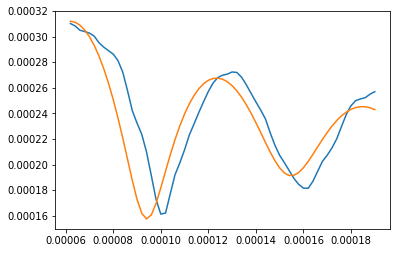

In [138]:
plt.plot(t_pdata[0:65],R_pdata[0:65],t_pdata[0:65],R1int[0:65])

#plt.plot(R1int/R0)
#plt.plot(((R_pdata/R0)-(R1int/R0))**2)
Rmax

<IPython.core.display.Javascript object>


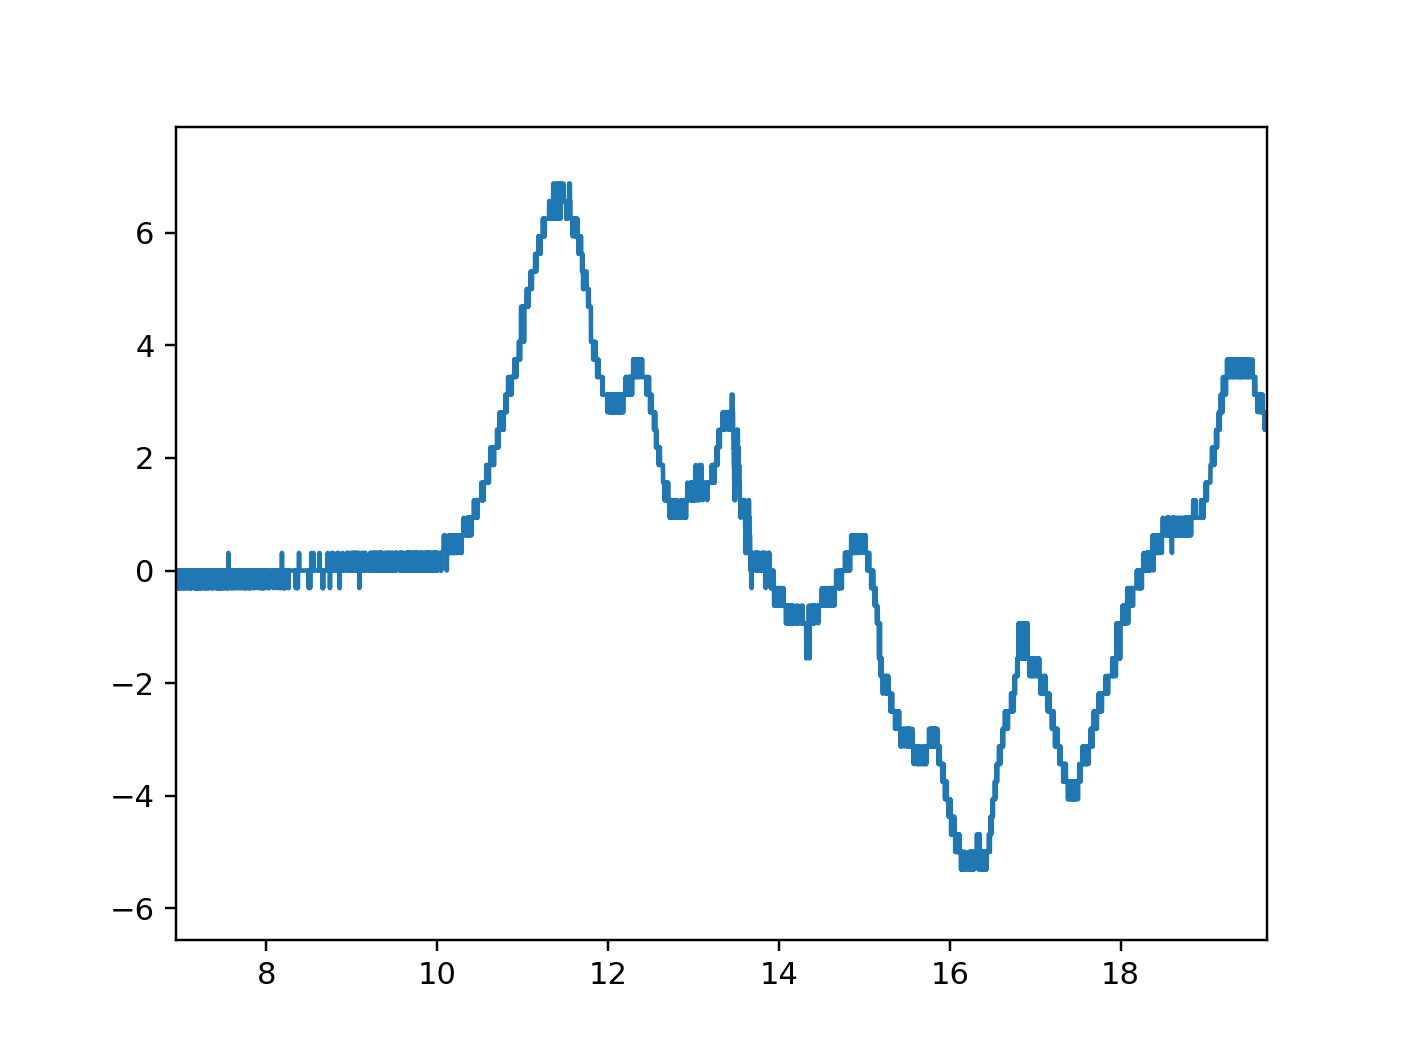

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.integrate as integrate
import numpy as np #work with arrays
import pandas as pd
 
df = pd.read_csv("/Users/cdohl/Documents/tempstore/siewwan/Camera1_15_00_13_BigBub_Hydrophone1mm_500k_7V.csv")
#th=df['time_microsec']
#ph=df['pressure_bar']
#ph=ph[np.where(th>130)[0][0]:].values*1e5*2.
#th=th[np.where(th>130)[0][0]:].values*1e-6
#reformate 
#th=np.linspace(0,(th[2]-th[1])*(th.size-1),th.size)

ph=(np.asarray(df['CH1'].values[1:-1],dtype=float))/1.28e-3*1e5
dt=float(df['Increment'].values[0])
th=np.linspace(0,len(ph)-1,len(ph))*dt
ts_i=np.where(th>140e-6)[0]
th=th-th[ts_i[0]]
plt.plot(th*1e6,ph/1e5)

In [7]:
np.interp(11e-6,th,ph)/1e5

4.062500000001058

In [ ]:
ph=np.asarray(df['CH1'].values[1:-1],dtype=float)
dt=float(df['Increment'].values[0])
th=np.linspace(0,len(ph)-1,len(ph))*dt
ts_i=np.where(th>1e-4)[0]
th=th-th[ts_i[0]]+25e-6
#ph=ph+np.interp(0.,th,ph)

In [ ]:
df['CH1']

In [ ]:
Rdf

In [ ]:
plt.plot(R_data[20:30])



In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(mov[28,:,:])
plt.subplot(2,2,2)
plt.imshow(mov[29,:,:])
plt.subplot(2,2,3)
plt.imshow(mov[30,:,:])
plt.subplot(2,2,4)
plt.imshow(mov[31,:,:])





In [ ]:
R_data[0]

In [11]:
a=np.array([1,2,3])
np.sum(a)


6

In [154]:
t_pdata[1]

6.2e-05

In [172]:
(25e-6)**2

6.25e-10

In [16]:
t_data*1e6-6.

array([ -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,
        16.,  18.,  20.,  22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,
        38.,  40.,  42.,  44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,
        60.,  62.,  64.,  66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,
        82.,  84.,  86.,  88.,  90.,  92.,  94.,  96.,  98., 100., 102.,
       104., 106., 108., 110., 112., 114., 116., 118., 120., 122., 124.,
       126., 128., 130., 132., 134., 136., 138., 140., 142., 144., 146.,
       148., 150., 152., 154., 156., 158., 160., 162., 164., 166., 168.,
       170., 172., 174., 176., 178., 180., 182., 184., 186., 188., 190.,
       192., 194., 196.])

In [26]:
kk=(np.asarray([kl[nn].area for nn in range(len(kl))])/np.pi)**.5

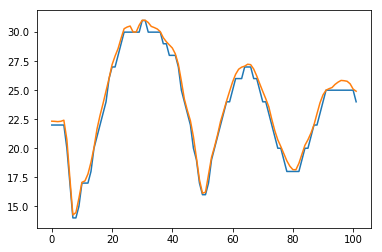

In [27]:
plt.plot(np.floor(kk))
plt.plot(kk)

In [31]:
kk.max();kk.min();

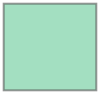

In [37]:
k.envelope

In [47]:
k.touches(k.envelope)

False

In [12]:
l.argmin()

2

In [26]:
print(r'$\nu=${:d}$\cdot 10^4$m$^2/$s'.format(int(nu1/1e-4)))

$\nu=$2$\cdot 10^4$m$^2/$s
